<div style="text-align: center"> <H1> <B>Forecasting Stock Return Volatility</B> </H1>  </div>


Aim of this project: Apply at least three out of five techniques illustrated in the course (Deep
Neural Network; Cross-validation; Ensemble Model; Autoencoder; Interpretability) to sovle a financial
problem. 

## Topic

Can we use deep neural network to forecast the stock return volatility? Which model provides the best
forcasting performance?

## Data
In computer lab_3_1, we show the method to download stock prices from Yahoo Finance. This topic uses
the stock adjusted prices to calculate its volatility (use the standard deviation of the past 30-day
arithmetic return as the volatility). 

## Method

The features include the downloaded five columns of Open, High, Low, Close, and Adj Close and the
calculated arithmetic return and current volatility. We may model the seven features as multi-dimensional
time series to forecast the future volatility over 𝐻 future horizons (𝐻 ≥ 1).
The features can be defined as a vector.

<div style="text-align: center"> 𝐗𝑡 = (𝑂𝑡, 𝐻𝑡, 𝐿𝑡, 𝐶𝑙𝑜𝑠𝑒𝑡, 𝐴𝑑𝑗𝐶𝑙𝑜𝑠𝑒𝑡, 𝑟𝑡 ,𝑉𝑂𝐿𝑡)T </div>

This project is to estimate the function 𝑓(∙), that takes a sequence of historical 𝐗𝑡 as input and generates
vector 𝐕𝐎𝐋𝑡 = (𝐕𝐎𝐋𝑡, 1, … , 𝐕𝐎𝐋𝑡, 𝐻)𝑇 as output: 

<div style="text-align: center"> 𝐕𝐎𝐋𝑡 = 𝑓(𝐗𝑡, 𝐗𝑡−1, 𝐗𝑡−2, … , 𝐗𝑡−𝑾). </div>

Where 𝑾 is the look back window, 𝑗 = 1, … , 𝐻.

This topic shall use LSTM as one of the potential models. You may try to train the LSTM model with the
raw 7-dimension features 𝐗𝑡 with different 𝑾. You may also extract the features with lower dimensions
𝑀 < 7 by autoencoder and then train the LSTM model using the extracted features with different 𝑾. You
can provide a comparison of those two methods.

This topic may also answer what look back window 𝑾 and horizon 𝐻 generate the best forecasting
results.

# Importing Libraries

In [35]:
import os
from os import listdir
import random
import tqdm
import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K

from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential
from scipy import stats

from pprint import pprint
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
# pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix
from scipy import stats
import scipy.cluster.hierarchy as sch
from keras.preprocessing.sequence import TimeseriesGenerator


# %matplotlib inline

# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

In [36]:
### install and import yahoo finance
!pip install yfinance
import yfinance as yf

# Download data

In [37]:
#### Define the stock Start and End Date ####

start = pd.to_datetime('20000101',format='%Y%m%d')
end = pd.to_datetime('20221231',format='%Y%m%d')
days = (end-start).days
print('total days: ', days)

ticker = 'GOOGL'
t0 = time.time()

df = yf.download(ticker, start=start, end=end, progress=False)

df.head()


total days:  8400


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044


In [38]:
# Calculate the daily returns of the stock price and drop any rows with missing data
df['Returns'] = df['Adj Close'].pct_change()
df.dropna(inplace=True)

# Calculate the 30-day rolling standard deviation of the daily returns and drop any rows with missing data
df['Volatility'] = df['Returns'].rolling(30).std()
df.dropna(inplace=True)

# Drop the 'Volume' column from the DataFrame
df.drop('Volume', inplace=True, axis=1)

# Make a copy of the DataFrame and display the first few rows
data = df.copy()
df.head()


,Open,High,Low,Close,Adj Close,Returns,Volatility
Date,,,,,,,
2004-10-01,3.273273,3.359359,3.225726,3.317818,3.317818,0.022994,0.026762
2004-10-04,3.384635,3.425175,3.354104,3.379880,3.379880,0.018706,0.023388
2004-10-05,3.369870,3.466717,3.309309,3.462713,3.462713,0.024508,0.023587
2004-10-06,3.442192,3.464715,3.403403,3.430430,3.430430,-0.009323,0.021933
2004-10-07,3.426426,3.500501,3.417167,3.474725,3.474725,0.012912,0.021942


# Visualize Adj Close, Returns and Volatility

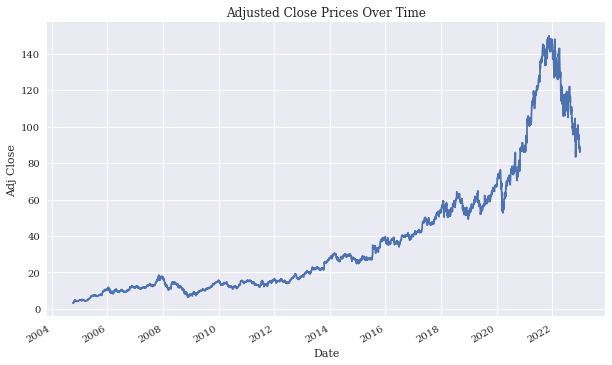

In [58]:
# Create a line plot of the 'Adj Close' column of the DataFrame
df['Adj Close'].plot(figsize=(10,6))

# Add axis labels and a title to the plot
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('Adjusted Close Prices Over Time')

# Display the plot
plt.show()


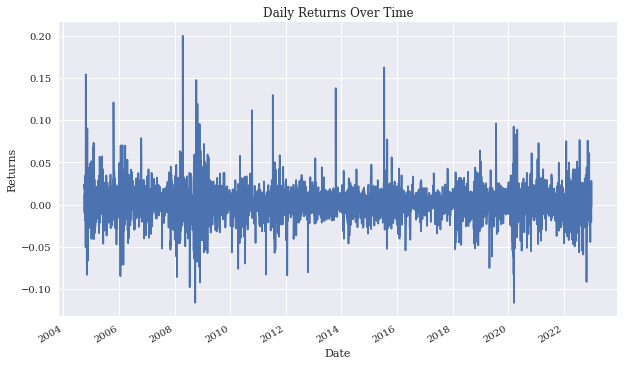

In [59]:
# Create a line plot of the 'Returns' column of the DataFrame
df['Returns'].plot(figsize=(10,6))

# Add axis labels and a title to the plot
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Daily Returns Over Time')

# Display the plot
plt.show()


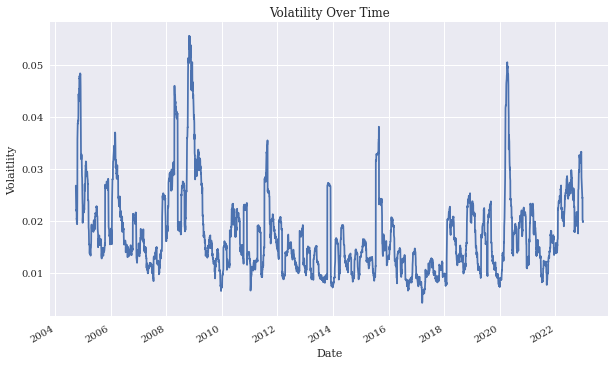

In [60]:
# Create a line plot of the 'Volatility' column of the DataFrame
df['Volatility'].plot(figsize=(10,6))

# Add axis labels and a title to the plot
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility Over Time')

# Display the plot
plt.show()


# Define Functions

In [42]:
# Define LSTM model architecture
def create_lstm_model(look_back, n_features, horizon):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(look_back, n_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=horizon))
    model.compile(optimizer='adam', loss='mse')
    return model

# Parameters

In [43]:
# Define features and targets
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Returns', 'Volatility']
X = df[features].values
y = df['Volatility'].values.reshape(-1, 1)


In [44]:
# Define parameters
look_back = 10
window = look_back
horizon = 1
n_features = len(features)
encoding_dim = 3
epochs = 30
batch_size = 3


# Data Splitting and Standardisation

In [45]:
# Split data into training, validation, and test sets
split = int(len(df) * 0.8)

# construct and normalize training and testing dataset
f_train_mu = df.iloc[:split].mean()
f_train_vol = df.iloc[:split].std()

train_df = df.iloc[:split]

f_train_data = (df.iloc[:split]-f_train_mu)/f_train_vol
f_test_data = (df.iloc[split:]-f_train_mu)/f_train_vol



In [46]:
f_train_data.head()


,Open,High,Low,Close,Adj Close,Returns,Volatility
Date,,,,,,,
2004-10-01,-1.281562,-1.279419,-1.280657,-1.278091,-1.278091,1.162920,1.174791
2004-10-04,-1.274460,-1.275255,-1.272401,-1.274134,-1.274134,0.936547,0.765444
2004-10-05,-1.275402,-1.272626,-1.275282,-1.268852,-1.268852,1.242829,0.789621
2004-10-06,-1.270789,-1.272753,-1.269230,-1.270910,-1.270910,-0.543059,0.588963
2004-10-07,-1.271795,-1.270489,-1.268345,-1.268086,-1.268086,0.630726,0.590027


In [47]:
f_train_data.values[:10]

array([[-1.2816, -1.2794, -1.2807, -1.2781, -1.2781,  1.1629,  1.1748],
       [-1.2745, -1.2753, -1.2724, -1.2741, -1.2741,  0.9365,  0.7654],
       [-1.2754, -1.2726, -1.2753, -1.2689, -1.2689,  1.2428,  0.7896],
       [-1.2708, -1.2728, -1.2692, -1.2709, -1.2709, -0.5431,  0.589 ],
       [-1.2718, -1.2705, -1.2683, -1.2681, -1.2681,  0.6307,  0.59  ],
       [-1.2689, -1.2708, -1.2676, -1.2699, -1.2699, -0.4767,  0.6091],
       [-1.2717, -1.2721, -1.2727, -1.2738, -1.2738, -0.9976,  0.617 ],
       [-1.2758, -1.2741, -1.2734, -1.2704, -1.2704,  0.7843,  0.3918],
       [-1.2616, -1.2647, -1.2627, -1.2648, -1.2648,  1.2938,  0.4097],
       [-1.2653, -1.2665, -1.2651, -1.2631, -1.2631,  0.3612,  0.3034]])

# LSTM

In [48]:
# make 5-lagged features as the X
''' batch_size is batch size defines the number samples that will be fed in each iteration of the model.
The difference between the different values of batch size are the model weight's optimization. 
If batch size is equal to 3, the model update the weights only after reading 3 samples.
'''

g_f = TimeseriesGenerator(f_train_data.values, f_train_data['Volatility'].values,
                        length=look_back, batch_size=batch_size)

# to print the first example of generated X and y

x,y = g_f[0]
print('%s => %s' % (x, y))

[[[-1.2816 -1.2794 -1.2807 -1.2781 -1.2781  1.1629  1.1748]
  [-1.2745 -1.2753 -1.2724 -1.2741 -1.2741  0.9365  0.7654]
  [-1.2754 -1.2726 -1.2753 -1.2689 -1.2689  1.2428  0.7896]
  [-1.2708 -1.2728 -1.2692 -1.2709 -1.2709 -0.5431  0.589 ]
  [-1.2718 -1.2705 -1.2683 -1.2681 -1.2681  0.6307  0.59  ]
  [-1.2689 -1.2708 -1.2676 -1.2699 -1.2699 -0.4767  0.6091]
  [-1.2717 -1.2721 -1.2727 -1.2738 -1.2738 -0.9976  0.617 ]
  [-1.2758 -1.2741 -1.2734 -1.2704 -1.2704  0.7843  0.3918]
  [-1.2616 -1.2647 -1.2627 -1.2648 -1.2648  1.2938  0.4097]
  [-1.2653 -1.2665 -1.2651 -1.2631 -1.2631  0.3612  0.3034]]

 [[-1.2745 -1.2753 -1.2724 -1.2741 -1.2741  0.9365  0.7654]
  [-1.2754 -1.2726 -1.2753 -1.2689 -1.2689  1.2428  0.7896]
  [-1.2708 -1.2728 -1.2692 -1.2709 -1.2709 -0.5431  0.589 ]
  [-1.2718 -1.2705 -1.2683 -1.2681 -1.2681  0.6307  0.59  ]
  [-1.2689 -1.2708 -1.2676 -1.2699 -1.2699 -0.4767  0.6091]
  [-1.2717 -1.2721 -1.2727 -1.2738 -1.2738 -0.9976  0.617 ]
  [-1.2758 -1.2741 -1.2734 -1.2704 -1.

In [49]:
model = create_lstm_model(look_back, n_features, horizon)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 10, 64)            18432     
                                                                 
 dropout_30 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_73 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


In [50]:
%%time
model.fit(g_f, epochs=epochs, verbose=False)


CPU times: total: 29.5 s
Wall time: 3min 39s


In [51]:
# construct data for testing
g_f_ = TimeseriesGenerator(f_test_data.values, f_test_data['Volatility'].values,
                        length=look_back, batch_size=batch_size)


In [52]:
#predict train
y_t = model.predict(g_f)

#predict test
y_f = model.predict(g_f_)

# recover from the normalization
y_t = (y_t.flatten()* f_train_vol['Volatility'] ) + f_train_mu['Volatility']
y_f = (y_f.flatten()* f_train_vol['Volatility'] ) + f_train_mu['Volatility']
print(y_f[:5])



# add testing results to pred column
df['pred'] = np.nan
df['pred'].iloc[look_back:split] = y_t 
df['pred'].iloc[split+look_back:] = y_f

MSE_t = ((df.iloc[look_back:split]['pred']-df.iloc[look_back:split]['Volatility'])**2).mean()
MSE = ((df.iloc[split+look_back:]['pred']-df.iloc[split+look_back:]['Volatility'])**2).mean()
print(f'RNN return Train MSE={MSE_t:.20f} ')
print(model.evaluate(g_f_))
print(f'RNN return Test MSE={MSE:.20f} ')

df.tail()

303/303 [==============================] - 1s 2ms/step
[0.0197 0.0196 0.0195 0.0197 0.0195]
RNN return Train MSE=0.00000342335169720174 
303/303 [==============================] - 1s 2ms/step - loss: 0.0921
0.09212217479944229
RNN return Test MSE=0.00000626011486979403 


,Open,High,Low,Close,Adj Close,Returns,Volatility,pred
Date,,,,,,,,
2022-12-23,87.110001,89.550003,87.070000,89.230003,89.230003,0.016750,0.020209,0.024589
2022-12-27,88.800003,88.940002,87.010002,87.389999,87.389999,-0.020621,0.019794,0.021472
2022-12-28,86.980003,88.040001,85.940002,86.019997,86.019997,-0.015677,0.019914,0.021100
2022-12-29,86.620003,88.849998,86.610001,88.449997,88.449997,0.028249,0.019893,0.020746
2022-12-30,86.980003,88.300003,86.570000,88.230003,88.230003,-0.002487,0.019843,0.020683


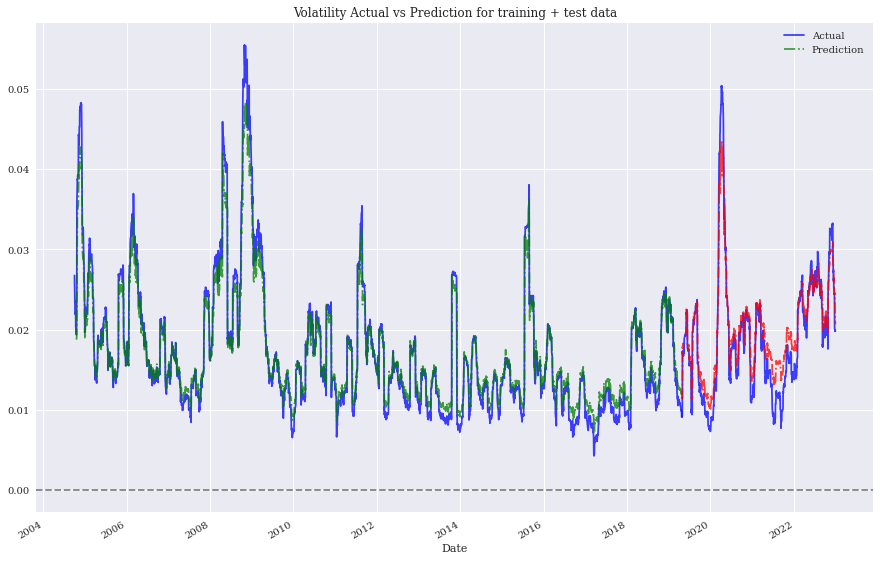

In [63]:
# plot the last 100 items
df[['Volatility', 'pred']].iloc[:len(y_t)].plot(
            figsize=(15, 10), style=['b', 'g-.'],
            alpha=0.75);

df[['Volatility', 'pred']].iloc[len(y_t):].plot(
            figsize=(15, 10), style=['b', 'r-.'],
            alpha=0.75, ax=plt.gca());
plt.axhline(0, c='grey', ls='--');
plt.title("Volatility Actual vs Prediction for training + test data")
plt.legend(['Actual', 'Prediction'])
plt.show()

Text(0.5, 1.0, 'Volatility Actual vs Prediction for test data')

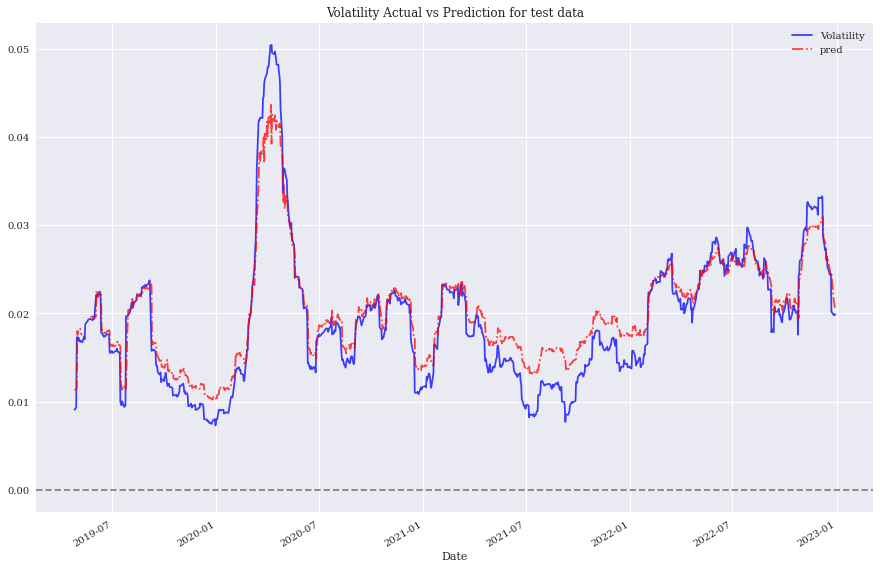

In [62]:
# plot the last 100 items

df[['Volatility', 'pred']].iloc[len(y_t):].plot(
            figsize=(15, 10), style=['b', 'r-.'],
            alpha=0.75);
plt.axhline(0, c='grey', ls='--');
plt.title("Volatility Actual vs Prediction for test data")


# Cross Validation

In [55]:
n_splits = 10

In [56]:
%%time
from sklearn.model_selection import TimeSeriesSplit
from keras.preprocessing.sequence import TimeseriesGenerator


ticker = ['GOOGL','AAPL', 'TSLA']
accuracy_cv = {}

for ticker in ticker:
    t0 = time.time()

    #download the data
    dfcv = yf.download(ticker, start=start, end=end, progress=False)

    #calculate the returns
    dfcv['Returns'] = dfcv['Adj Close'].pct_change()
    dfcv.dropna(inplace=True)

    #calculate the volatility
    dfcv['Volatility'] = dfcv['Returns'].rolling(30).std() 
    dfcv.dropna(inplace=True)
    dfcv.drop('Volume', inplace=True, axis=1)

    # Split the time series data using TimeSeriesSplit

    # calculate the length of the training window by all above variables
    # train_window = X.shape - n_windows* (test_window + n_gap)
    features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Returns', 'Volatility']
    X = dfcv[features].values
    y = dfcv['Volatility'].values.reshape(-1, 1)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    accuracy = []

    # Loop through the folds and train the LSTM model
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        # construct and normalize training and testing dataset
        f_train_mu = X_train.mean()
        f_train_vol = X_train.std()

        X_train_data = (X_train-f_train_mu)/f_train_vol
        X_test_data = (X_test-f_train_mu)/f_train_vol

        # Create a TimeSeriesGenerator object to generate input/output data pairs for the LSTM model
        train_generator = TimeseriesGenerator(X_train_data.values, X_train_data.iloc[:,-1].values,
                                              length=look_back, batch_size=batch_size)

        test_generator = TimeseriesGenerator(X_test_data.values, X_test_data.iloc[:,-1].values,
                                             length=look_back, batch_size=batch_size)


        # Train the LSTM model
        model.fit(train_generator, epochs=epochs, verbose=False)


        # Evaluate the LSTM model
        train_score = model.evaluate(train_generator, verbose=0)
    #     print('Train Score: {:.5f} MSE ({:.5f} RMSE)'.format(train_score, np.sqrt(train_score)))
        test_score = model.evaluate(test_generator, verbose=0)
    #     print('Test Score: {:.5f} MSE ({:.5f} RMSE)'.format(test_score, np.sqrt(test_score)))

        accuracy.append(test_score)
    
    accuracy_cv[ticker] = accuracy
    
    


CPU times: total: 18min 37s
Wall time: 1h 13min 38s


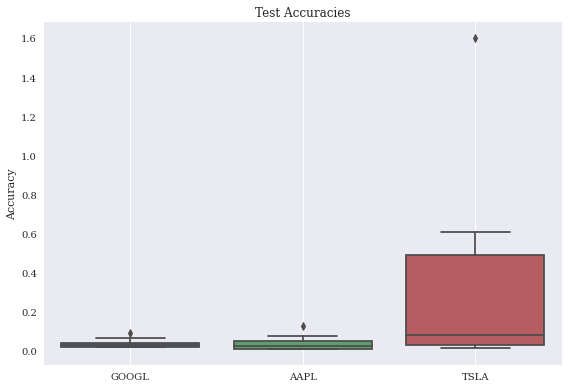

In [57]:
data_cv = pd.DataFrame.from_dict(accuracy_cv, orient='index').transpose()

# create boxplot using seaborn
sns.boxplot(data=data_cv)
# set the title and axis labels
plt.title('Test Accuracies')
plt.ylabel('Accuracy')
plt.grid()
# show the plot
plt.tight_layout()
plt.show()

In [98]:
data_cv

,GOOGL,AAPL,TSLA
0,0.028329,0.012763,0.157195
1,0.065640,0.125977,1.601173
2,0.018068,0.053130,0.050518
3,0.017290,0.018461,0.032007
4,0.031920,0.073508,0.014799
5,0.041226,0.010088,0.021561
6,0.026706,0.007547,0.113757
7,0.031229,0.009100,0.603686
8,0.090780,0.038261,0.605392
9,0.018795,0.027473,0.025350


# LSTM + AUTOENCODER

In [65]:
df = data.copy()

# construct a new column with tag of train or test

# total days in dataset
Time_diff = df.index[-1] - df.index[0]
print(Time_diff.days, 'days in the dataset')

# ratio of data for test
test_ratio = 0.2

# index splitting train and test data
test_index = df.index[0] + (Time_diff*(1-test_ratio))

# create a new column of test flag
df['test_flag'] = False                                  #all false for training
df.loc[ test_index : df.index[-1], 'test_flag' ] = True  #some data for testing based on test_ratio

6664 days in the dataset


In [66]:
### CREATE GENERATOR FOR LSTM WINDOWS AND LABELS ###
window = 10
horizon=1
# the length of each training sample (how many time steps in each sample)
sequence_length = window

def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

# zip takes an iterable (list, tuple, set, or dictionary), generates a list of tuples that contain elements from each iterable
# construct LSTM input features
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


# construct LSTM output
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [67]:
### CREATE TRAIN/TEST PRICE DATA ###

col = df.columns

X_train, X_test = [], []
y_train, y_test = [], []

for (is_test), _df in df.groupby(['test_flag']):
    
    for seq in gen_sequence(_df, sequence_length, col):        
        if is_test:
            X_test.append(seq)
        else:
            X_train.append(seq)
                
    for seq in gen_labels(_df, sequence_length, ['Volatility']):        
        if is_test:
            y_test.append(seq)
        else:
            y_train.append(seq)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print('shape of the intput X and output y\ninput training data dimension: ')
print(X_train.shape)
print('\noutput training data dimension: ')
print(y_train.shape)

print('\ninput testing data dimension: ')
print(X_test.shape)
print('\noutput testing data dimension: ')
print(y_test.shape)


shape of the intput X and output y
input training data dimension: 
(3664, 10, 8)

output training data dimension: 
(3664, 1)

input testing data dimension: 
(911, 10, 8)

output testing data dimension: 
(911, 1)


In [68]:
X_train = X_train[:,:,:-1]
X_test = X_test[:,:,:-1]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

29/29 [==============================] - 0s 2ms/step
encoded features:  (3664, 10, 1)
original training data shape:  (3664, 10, 7)
original testing data shape:  (911, 10, 7)
29/29 [==============================] - 0s 4ms/step


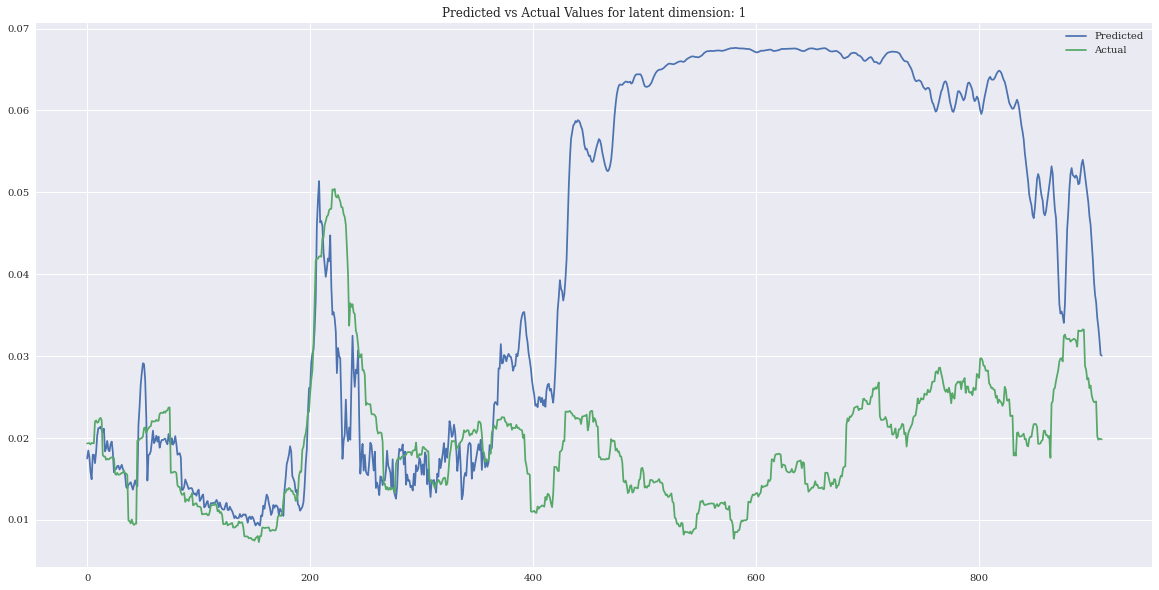

29/29 [==============================] - 0s 2ms/step
encoded features:  (3664, 10, 2)
original training data shape:  (3664, 10, 7)
original testing data shape:  (911, 10, 7)
29/29 [==============================] - 0s 4ms/step


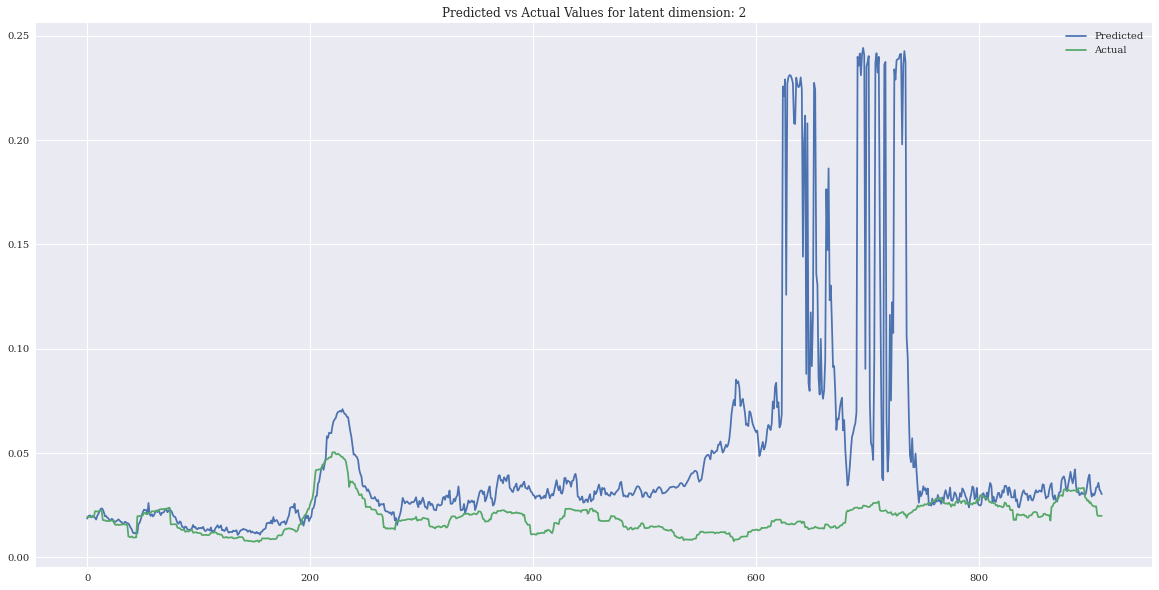

29/29 [==============================] - 0s 2ms/step
encoded features:  (3664, 10, 3)
original training data shape:  (3664, 10, 7)
original testing data shape:  (911, 10, 7)
29/29 [==============================] - 0s 3ms/step


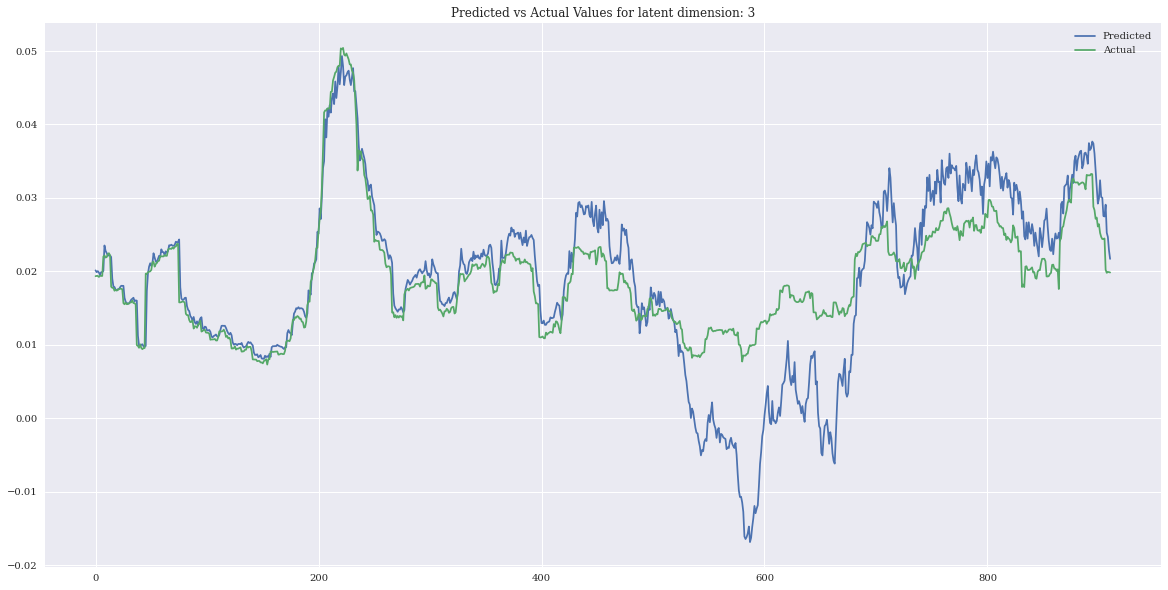

29/29 [==============================] - 0s 2ms/step
encoded features:  (3664, 10, 4)
original training data shape:  (3664, 10, 7)
original testing data shape:  (911, 10, 7)
29/29 [==============================] - 0s 3ms/step


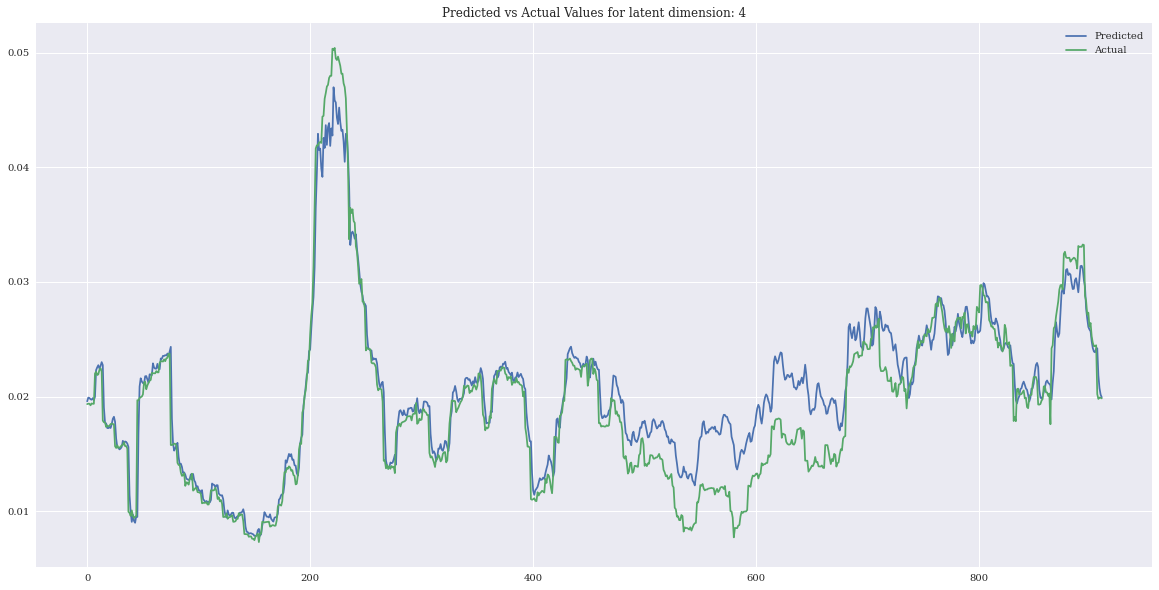

29/29 [==============================] - 0s 2ms/step
encoded features:  (3664, 10, 5)
original training data shape:  (3664, 10, 7)
original testing data shape:  (911, 10, 7)
29/29 [==============================] - 0s 3ms/step


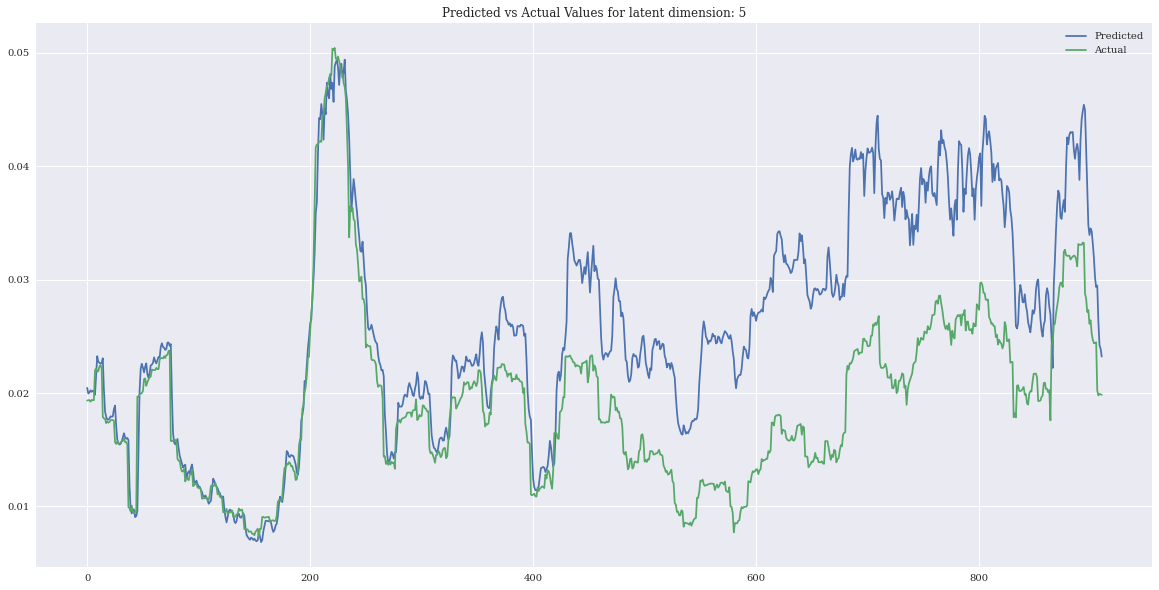

29/29 [==============================] - 0s 2ms/step
encoded features:  (3664, 10, 6)
original training data shape:  (3664, 10, 7)
original testing data shape:  (911, 10, 7)
29/29 [==============================] - 0s 3ms/step


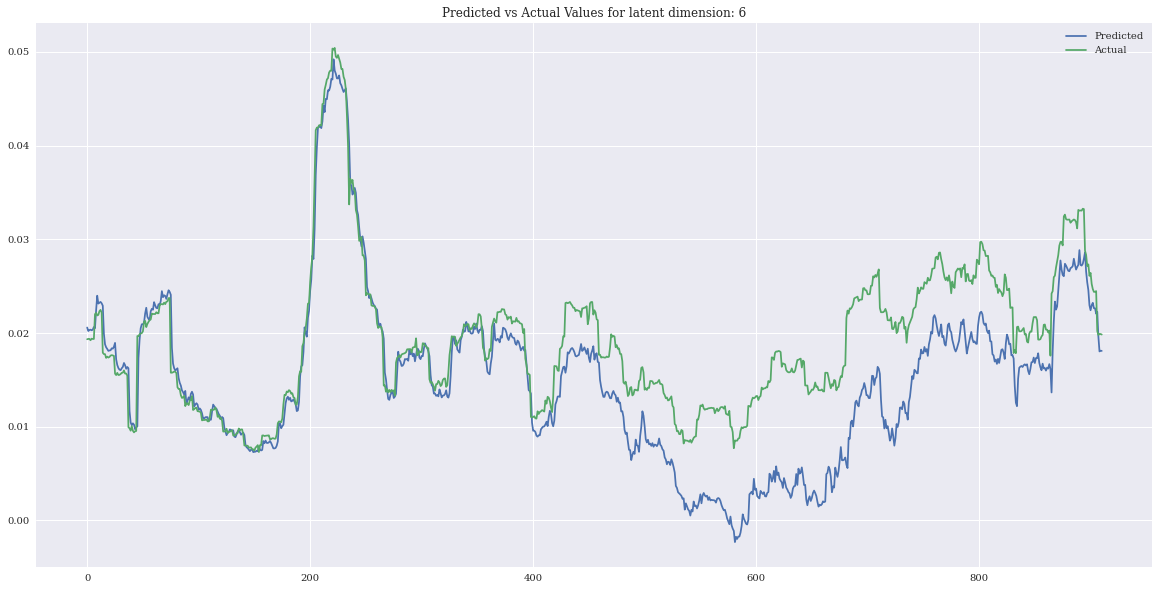

In [70]:
dimensions = [1,2,3,4,5,6]
mse_test_ae = []
# construct model
for latent_dim in dimensions:
    ### DEFINE LSTM AUTOENCODER ###

    inputs_ae = Input(shape=(X_train.shape[1:]))

    # encoding LSTM layer, receive inputs_ae from input layer
    encoded_ae_2 = LSTM( int(X_train.shape[2]), return_sequences=True)(inputs_ae, training=True)

    encoded = LSTM( latent_dim , return_sequences=True)(encoded_ae_2, training=True)

    # decoding LSTM layer, recive encoded_ae from encoding LSTM layer
    decoded_ae = LSTM( int(X_train.shape[2]) , return_sequences=True)(encoded, training=True)

    out_ae = TimeDistributed(Dense(X_train.shape[2]))(decoded_ae)

    sequence_autoencoder = Model(inputs_ae, out_ae)
    sequence_autoencoder.compile(optimizer='adam', loss='mse')

    ### TRAIN AUTOENCODER ###

    # early stop
    es = EarlyStopping(patience=10, verbose=2,  
                       monitor='val_loss', mode='auto', restore_best_weights=True)

    # train autoencoder with output reconstructing the input
    sequence_autoencoder.fit(X_train, X_train, validation_data=(X_train, X_train),
                             batch_size=128, epochs=350, verbose=False, callbacks=[es])

    ### ENCODE PRICE AND CONCATENATE REGRESSORS ###
    encoder = Model(inputs_ae, encoded)
    encoded_feature_train = encoder.predict(X_train)
    encoded_feature_test = encoder.predict(X_test)

    # dimension of encoded features
    print('encoded features: ', encoded_feature_train.shape)

    X_train_ = encoded_feature_train
    X_test_ = encoded_feature_test

    # original data
    print('original training data shape: ', X_train.shape)
    print('original testing data shape: ', X_test.shape)

    model_lstm = create_lstm_model(sequence_length, latent_dim, horizon)

    model_lstm.compile(loss='mse', optimizer='adam')

    ### FIT FORECASTER ###
    model_lstm.fit(X_train_, y_train, epochs=50,
                   batch_size=15,verbose=False)

    y_pred = model_lstm.predict(X_train_)
    y_pred_ = model_lstm.predict(X_test_)

    mse_test_a = mean_squared_error(y_test, y_pred_)
    rows = {'Latent_dimension': latent_dim, 'mse_test': mse_test_a}
    mse_test_ae.append(rows)

    plt.figure(figsize=(20,10))
    plt.plot(y_pred_, label='Predicted')
    plt.plot(y_test, label='Actual')
    plt.title(f'Predicted vs Actual Values for latent dimension: {latent_dim}')
    plt.legend()
    plt.show()

In [73]:
# create the DataFrame from the list of dictionaries
mse_ae = pd.DataFrame(mse_test_ae)
mse_ae.set_index('Latent_dimension', inplace=True)
mse_ae

,mse_test
Latent_dimension,
1,0.001034
2,0.003099
3,0.000048
4,0.000007
5,0.000081
6,0.000038


# Horizon and Look Back 

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_109 (LSTM)             (None, 5, 64)             18432     
                                                                 
 dropout_46 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_110 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_47 (Dropout)        (None, 32)                0         
                                                                 
 dense_44 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________
305/305 [==============================] - 1s 2ms

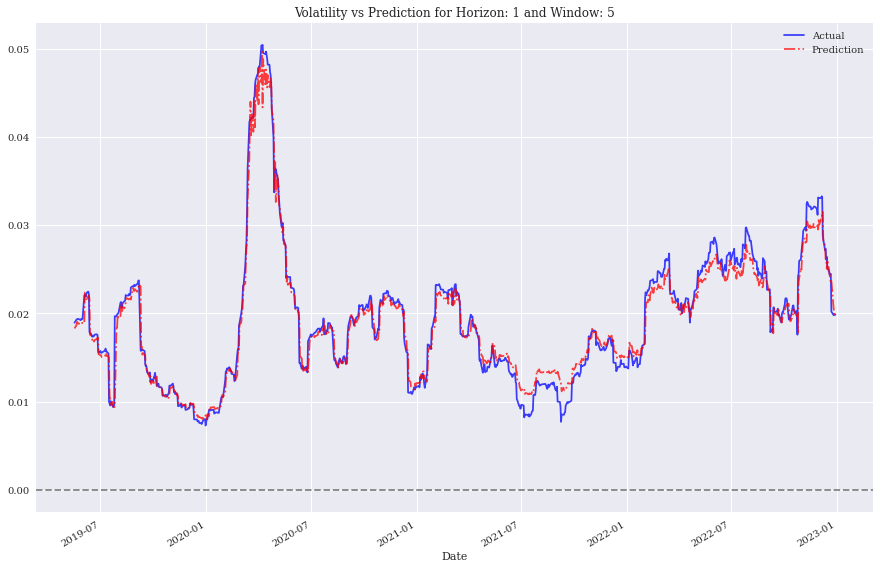

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_111 (LSTM)             (None, 10, 64)            18432     
                                                                 
 dropout_48 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_112 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_49 (Dropout)        (None, 32)                0         
                                                                 
 dense_45 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________
303/303 [==============================] - 1s 2ms

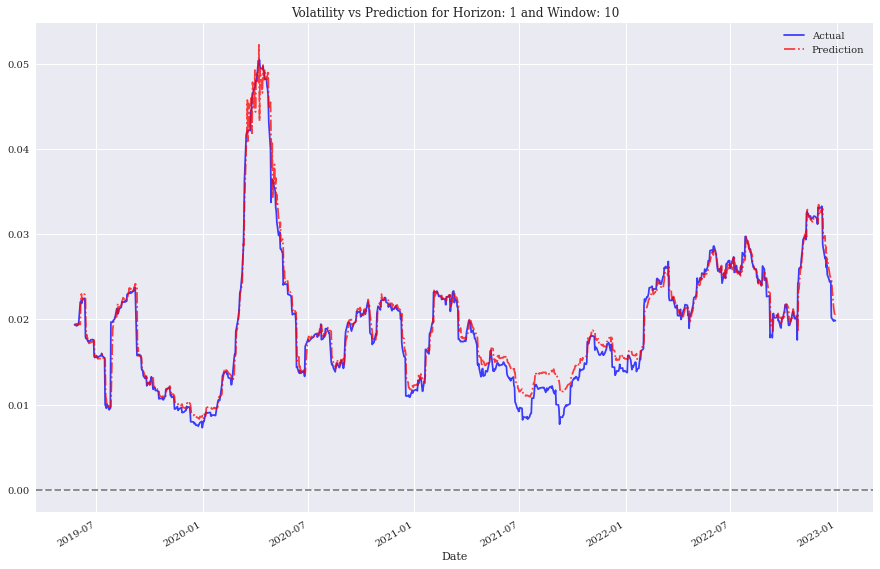

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_113 (LSTM)             (None, 20, 64)            18432     
                                                                 
 dropout_50 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_114 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_51 (Dropout)        (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________
300/300 [==============================] - 1s 3ms

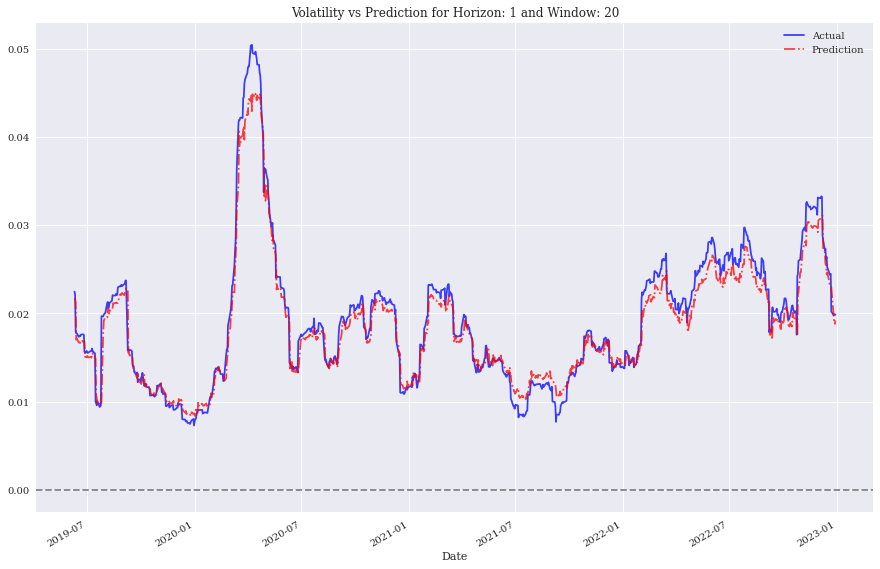

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_115 (LSTM)             (None, 30, 64)            18432     
                                                                 
 dropout_52 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_116 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_53 (Dropout)        (None, 32)                0         
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________
297/297 [==============================] - 1s 3ms

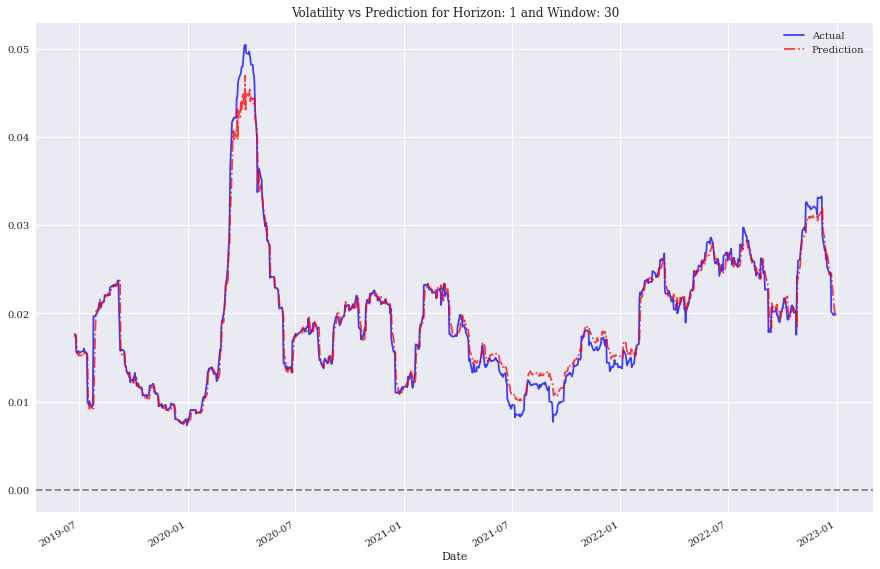

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 5, 64)             18432     
                                                                 
 dropout_54 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_118 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_55 (Dropout)        (None, 32)                0         
                                                                 
 dense_48 (Dense)            (None, 5)                 165       
                                                                 
Total params: 31,013
Trainable params: 31,013
Non-trainable params: 0
_________________________________________________________________
305/305 [==============================] - 1s 2ms

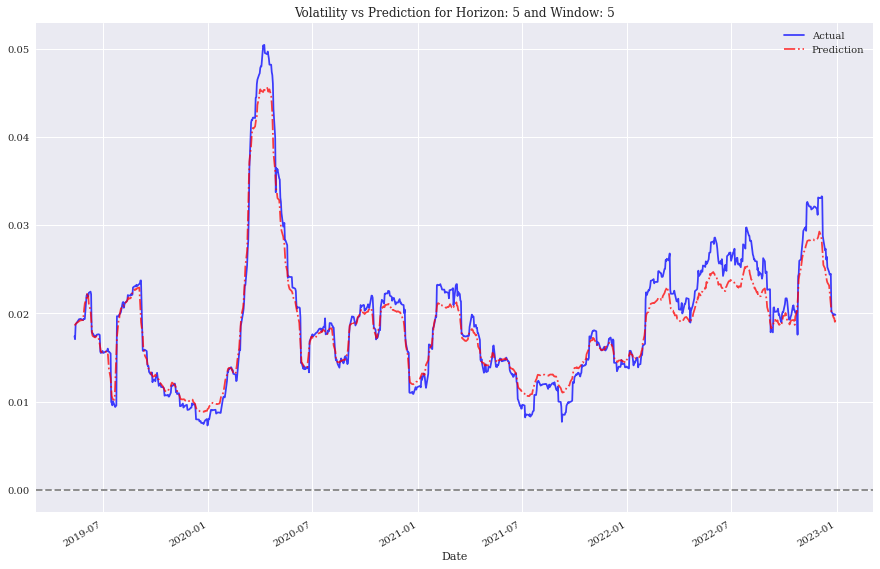

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_119 (LSTM)             (None, 10, 64)            18432     
                                                                 
 dropout_56 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_120 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_57 (Dropout)        (None, 32)                0         
                                                                 
 dense_49 (Dense)            (None, 5)                 165       
                                                                 
Total params: 31,013
Trainable params: 31,013
Non-trainable params: 0
_________________________________________________________________
303/303 [==============================] - 1s 2ms

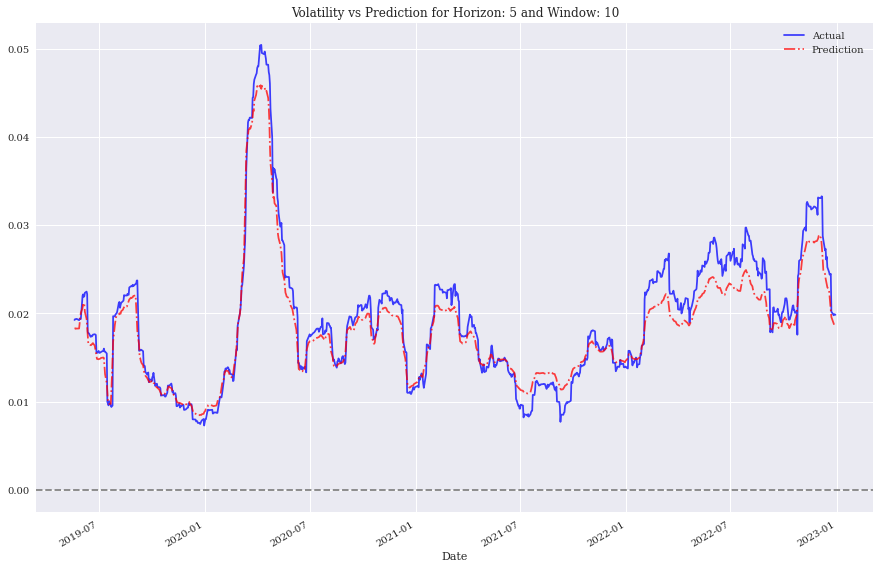

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_121 (LSTM)             (None, 20, 64)            18432     
                                                                 
 dropout_58 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_122 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_59 (Dropout)        (None, 32)                0         
                                                                 
 dense_50 (Dense)            (None, 5)                 165       
                                                                 
Total params: 31,013
Trainable params: 31,013
Non-trainable params: 0
_________________________________________________________________
300/300 [==============================] - 1s 3ms

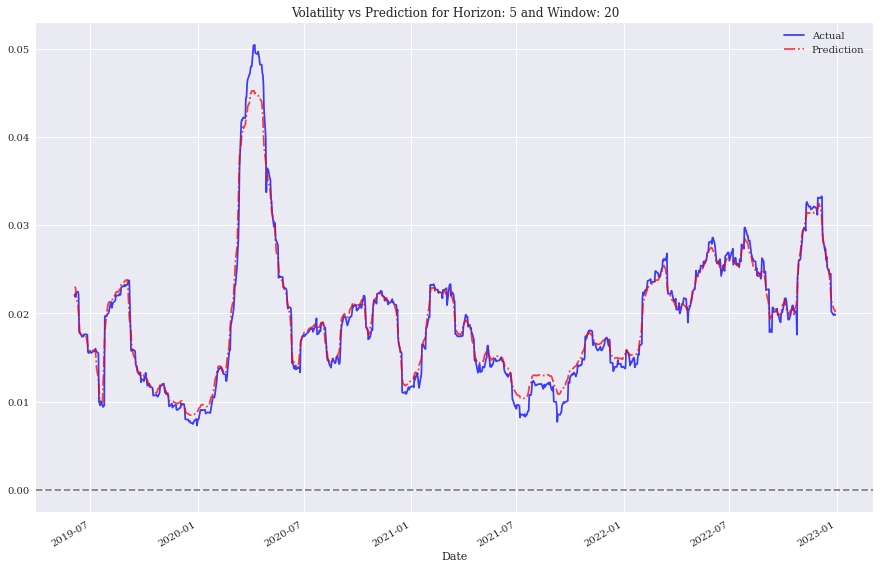

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_123 (LSTM)             (None, 30, 64)            18432     
                                                                 
 dropout_60 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_124 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_61 (Dropout)        (None, 32)                0         
                                                                 
 dense_51 (Dense)            (None, 5)                 165       
                                                                 
Total params: 31,013
Trainable params: 31,013
Non-trainable params: 0
_________________________________________________________________
297/297 [==============================] - 1s 3ms

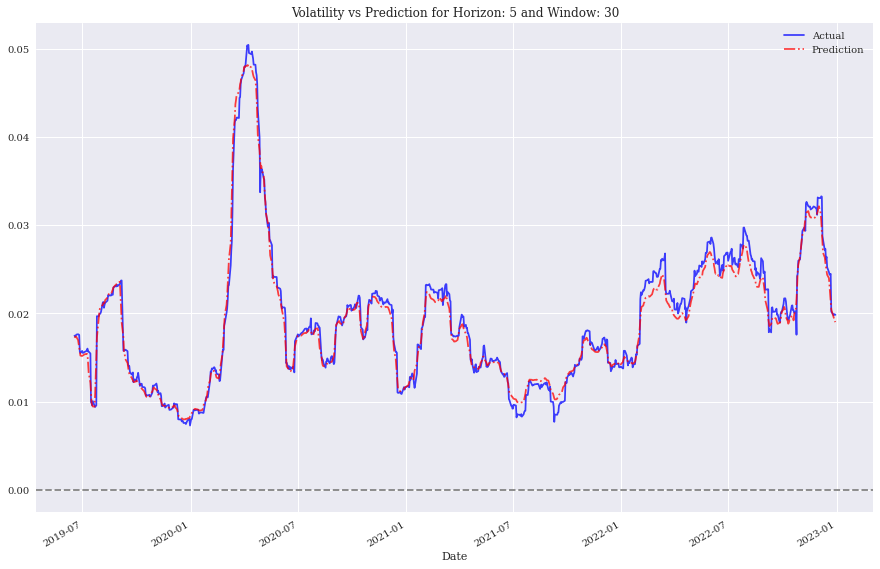

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_125 (LSTM)             (None, 5, 64)             18432     
                                                                 
 dropout_62 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_126 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_63 (Dropout)        (None, 32)                0         
                                                                 
 dense_52 (Dense)            (None, 10)                330       
                                                                 
Total params: 31,178
Trainable params: 31,178
Non-trainable params: 0
_________________________________________________________________
305/305 [==============================] - 1s 2ms

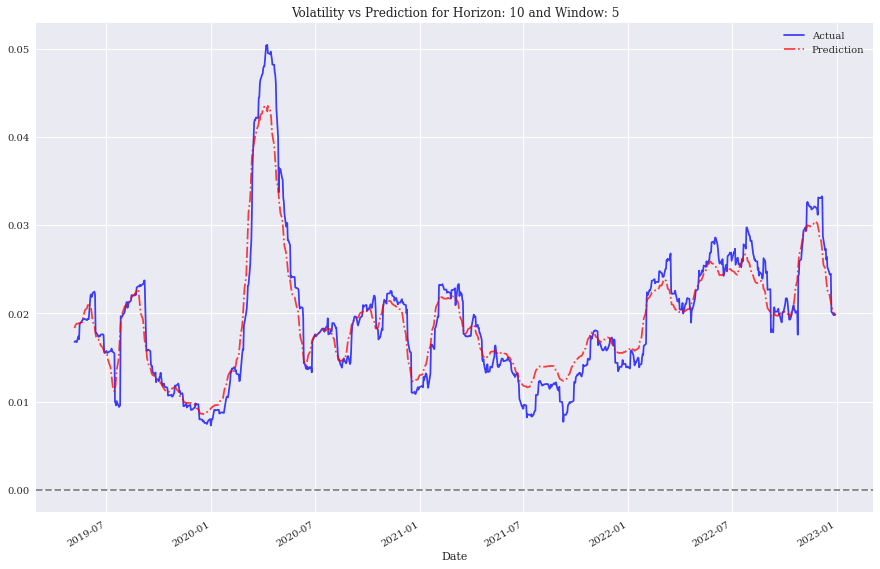

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_127 (LSTM)             (None, 10, 64)            18432     
                                                                 
 dropout_64 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_128 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_65 (Dropout)        (None, 32)                0         
                                                                 
 dense_53 (Dense)            (None, 10)                330       
                                                                 
Total params: 31,178
Trainable params: 31,178
Non-trainable params: 0
_________________________________________________________________
303/303 [==============================] - 1s 2ms

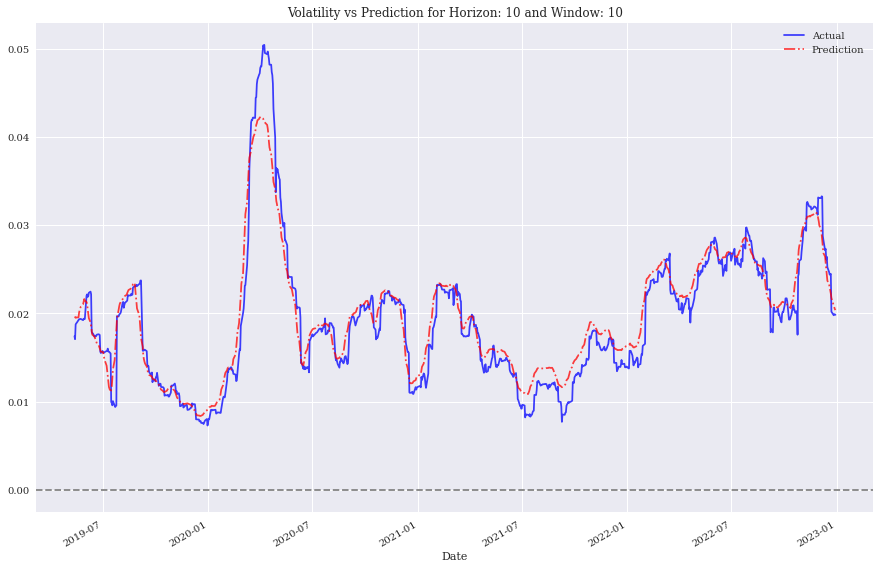

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_129 (LSTM)             (None, 20, 64)            18432     
                                                                 
 dropout_66 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_130 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_67 (Dropout)        (None, 32)                0         
                                                                 
 dense_54 (Dense)            (None, 10)                330       
                                                                 
Total params: 31,178
Trainable params: 31,178
Non-trainable params: 0
_________________________________________________________________
300/300 [==============================] - 1s 3ms

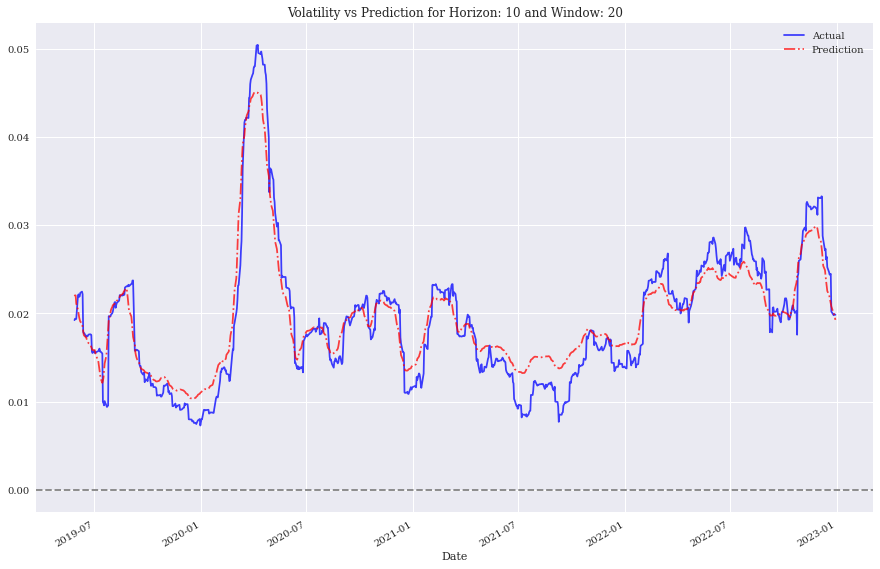

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_131 (LSTM)             (None, 30, 64)            18432     
                                                                 
 dropout_68 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_132 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_69 (Dropout)        (None, 32)                0         
                                                                 
 dense_55 (Dense)            (None, 10)                330       
                                                                 
Total params: 31,178
Trainable params: 31,178
Non-trainable params: 0
_________________________________________________________________
297/297 [==============================] - 1s 4ms

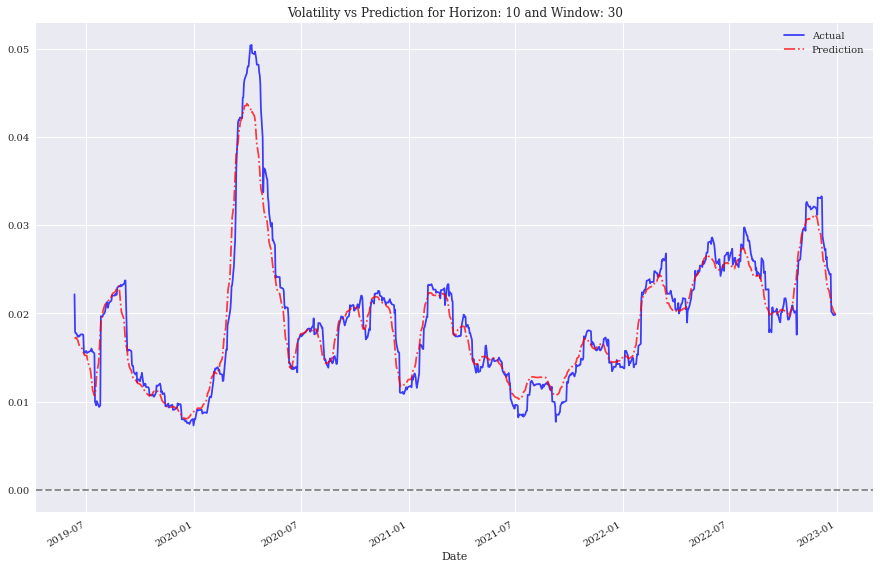

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_133 (LSTM)             (None, 5, 64)             18432     
                                                                 
 dropout_70 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_134 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_71 (Dropout)        (None, 32)                0         
                                                                 
 dense_56 (Dense)            (None, 15)                495       
                                                                 
Total params: 31,343
Trainable params: 31,343
Non-trainable params: 0
_________________________________________________________________
305/305 [==============================] - 1s 2ms

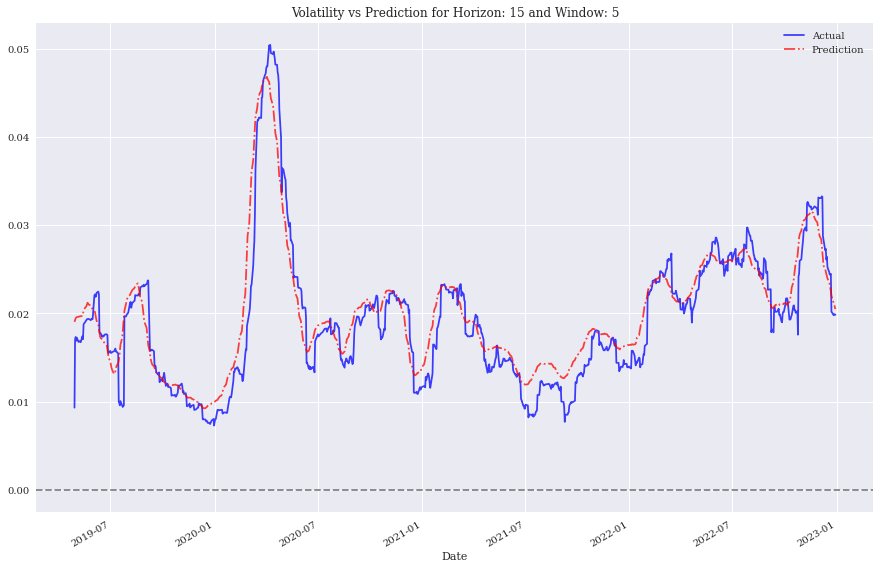

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_135 (LSTM)             (None, 10, 64)            18432     
                                                                 
 dropout_72 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_136 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_73 (Dropout)        (None, 32)                0         
                                                                 
 dense_57 (Dense)            (None, 15)                495       
                                                                 
Total params: 31,343
Trainable params: 31,343
Non-trainable params: 0
_________________________________________________________________
303/303 [==============================] - 1s 2ms

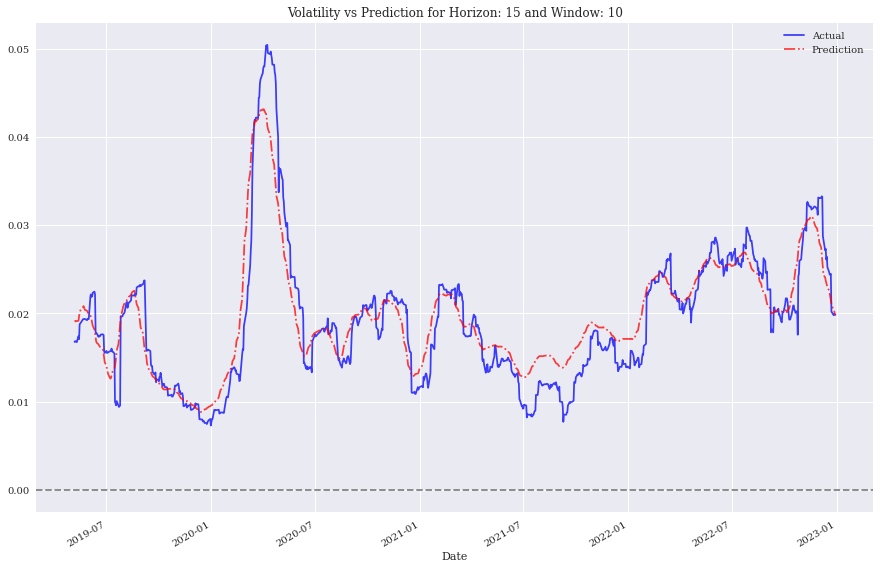

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_137 (LSTM)             (None, 20, 64)            18432     
                                                                 
 dropout_74 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_138 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_75 (Dropout)        (None, 32)                0         
                                                                 
 dense_58 (Dense)            (None, 15)                495       
                                                                 
Total params: 31,343
Trainable params: 31,343
Non-trainable params: 0
_________________________________________________________________
300/300 [==============================] - 1s 3ms

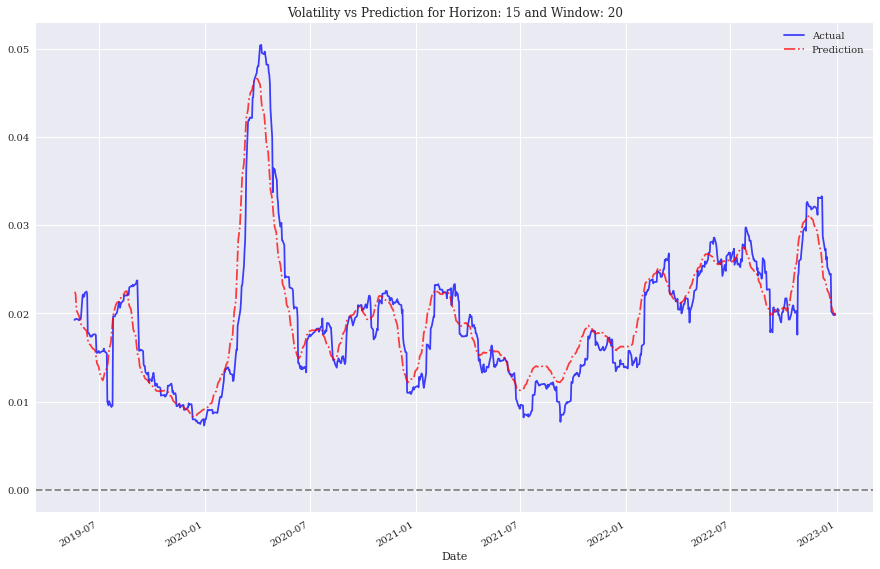

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_139 (LSTM)             (None, 30, 64)            18432     
                                                                 
 dropout_76 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_140 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_77 (Dropout)        (None, 32)                0         
                                                                 
 dense_59 (Dense)            (None, 15)                495       
                                                                 
Total params: 31,343
Trainable params: 31,343
Non-trainable params: 0
_________________________________________________________________
297/297 [==============================] - 1s 3ms

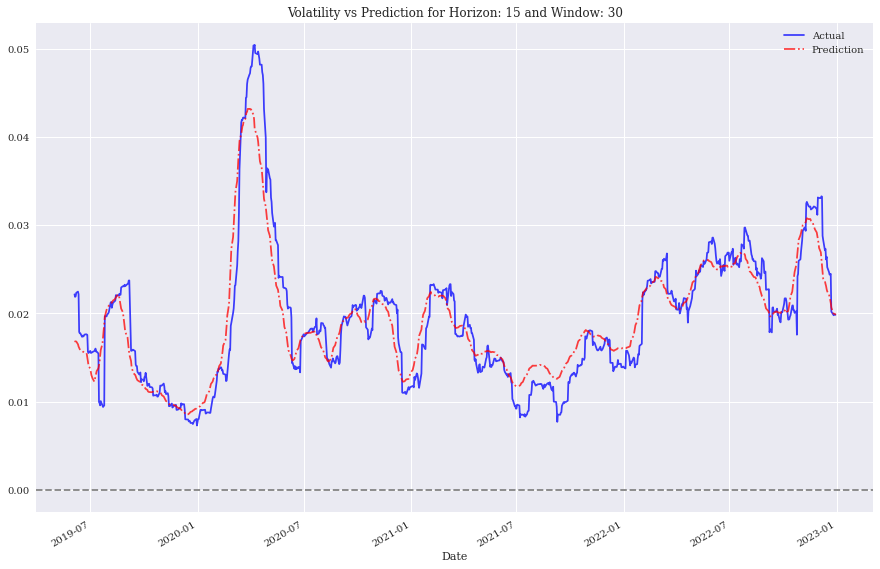

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_141 (LSTM)             (None, 5, 64)             18432     
                                                                 
 dropout_78 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_142 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_79 (Dropout)        (None, 32)                0         
                                                                 
 dense_60 (Dense)            (None, 30)                990       
                                                                 
Total params: 31,838
Trainable params: 31,838
Non-trainable params: 0
_________________________________________________________________
305/305 [==============================] - 1s 2ms

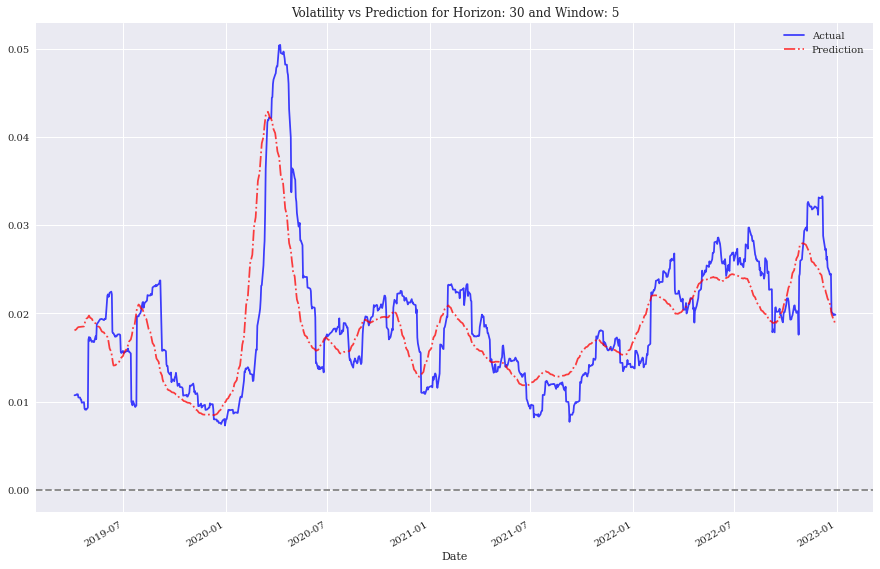

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_143 (LSTM)             (None, 10, 64)            18432     
                                                                 
 dropout_80 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_144 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_81 (Dropout)        (None, 32)                0         
                                                                 
 dense_61 (Dense)            (None, 30)                990       
                                                                 
Total params: 31,838
Trainable params: 31,838
Non-trainable params: 0
_________________________________________________________________
303/303 [==============================] - 1s 2ms

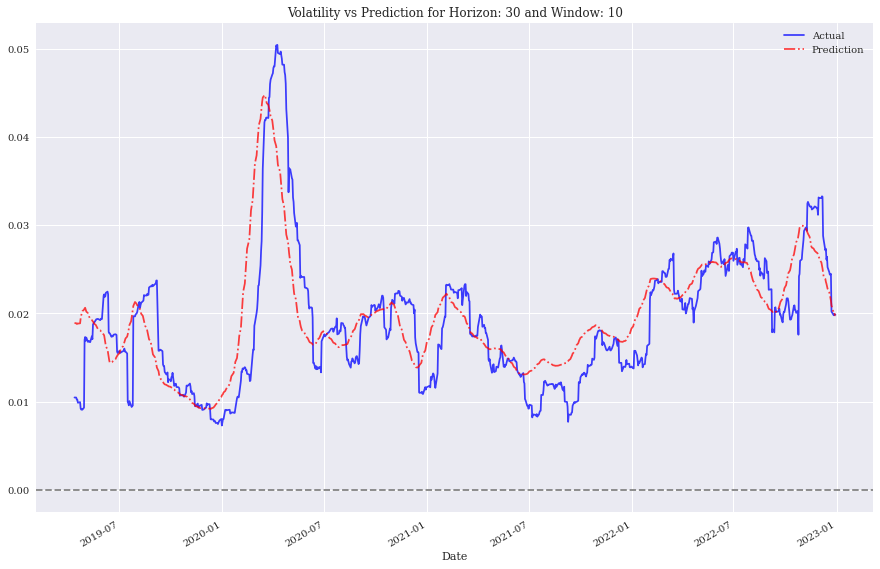

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_145 (LSTM)             (None, 20, 64)            18432     
                                                                 
 dropout_82 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_146 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_83 (Dropout)        (None, 32)                0         
                                                                 
 dense_62 (Dense)            (None, 30)                990       
                                                                 
Total params: 31,838
Trainable params: 31,838
Non-trainable params: 0
_________________________________________________________________
300/300 [==============================] - 1s 3ms

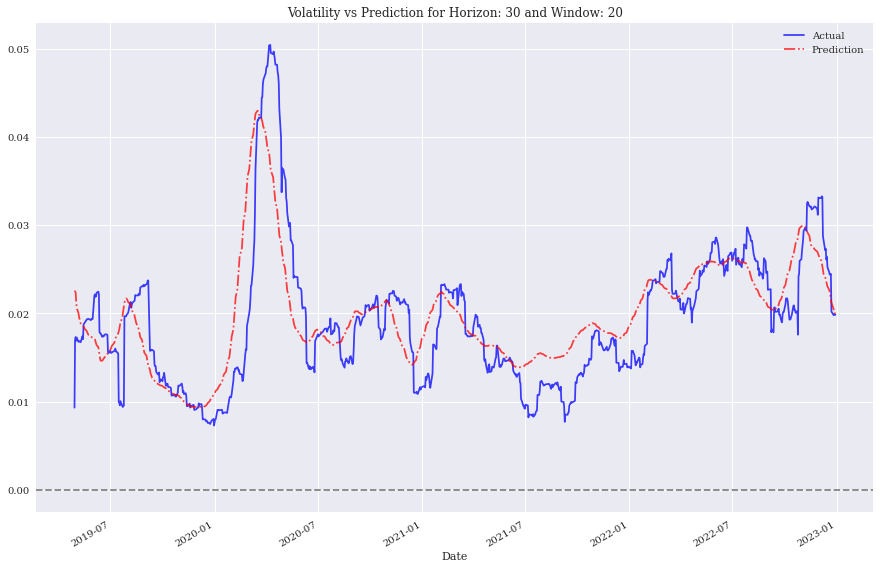

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_147 (LSTM)             (None, 30, 64)            18432     
                                                                 
 dropout_84 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_148 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_85 (Dropout)        (None, 32)                0         
                                                                 
 dense_63 (Dense)            (None, 30)                990       
                                                                 
Total params: 31,838
Trainable params: 31,838
Non-trainable params: 0
_________________________________________________________________
297/297 [==============================] - 1s 4ms

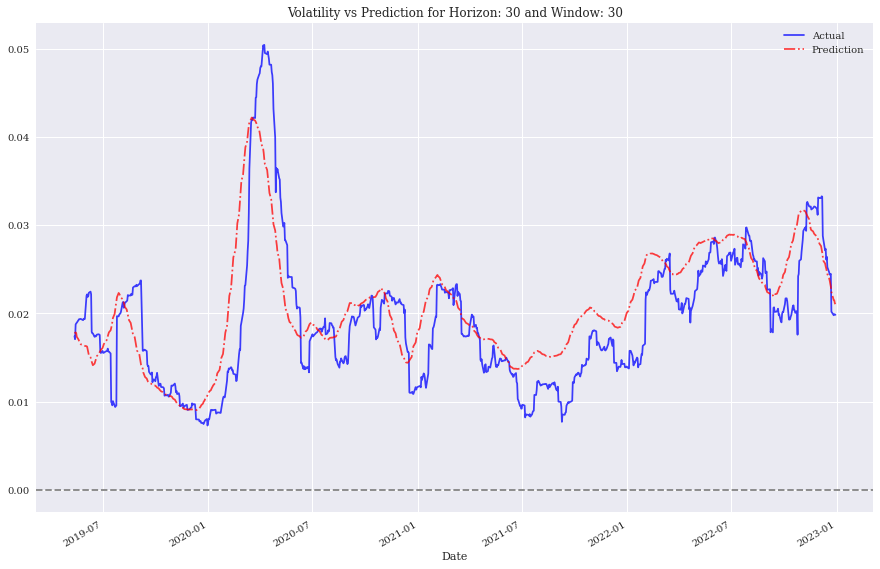

CPU times: total: 21min 33s
Wall time: 1h 47min 33s


In [74]:
%%time
horizon_list = [1,5,10,15,30]
look_back_list = [5,10,20,30]
mse_test = []

for horizon in horizon_list:
    for look_back in look_back_list:

        dfa = data.copy()

        # Define features and targets
        features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Returns', 'Volatility']
        Xa = dfa[features].values
        ya = dfa['Volatility'].values.reshape(-1, 1)


        # Define parameters
        n_features = len(features)
        epochs = 30
        batch_size = 3

        # Split data into training, validation, and test sets
        split = int(len(dfa) * 0.8)

        # construct and normalize training and testing dataset
        f_train_m = dfa.iloc[:split].mean()
        f_train_vo = dfa.iloc[:split].std()

        f_train_data = (dfa.iloc[:split]-f_train_m)/f_train_vo
        f_test_data = (dfa.iloc[split:]-f_train_m)/f_train_vo

        g_fa = TimeseriesGenerator(f_train_data.values, f_train_data['Volatility'].values,
                                length=look_back, batch_size=batch_size)

    #     defining model
        modela = create_lstm_model(look_back, n_features, horizon)
        modela.summary()

    #     model fitting
        modela.fit(g_fa, epochs=epochs, verbose=False)

        # construct data for testing
        g_f_a = TimeseriesGenerator(f_test_data.values, f_test_data['Volatility'].values,
                                length=look_back, batch_size=batch_size)

    #     making the prediction
        y_ta = modela.predict(g_fa)
        y_fa = modela.predict(g_f_a)

    #     denormalizing the data
        ytry = y_ta.reshape(-1)
        yfry = y_fa.reshape(-1)
        ytry = (ytry* f_train_vo['Volatility'] ) + f_train_m['Volatility']
        yfry = (yfry* f_train_vo['Volatility'] ) + f_train_m['Volatility']

        ytest = dfa['Volatility'].iloc[split+look_back-horizon+1:].values
        ynew = np.array([[ytest[i+j] for j in range(horizon)] for i in range(len(ytest)-horizon+1)])
        ynew = ynew.reshape(-1)

        # Calculate mean squared error
        mse_test_h = mean_squared_error(ynew, yfry)
        row = {'horizon': horizon, 'look_back': look_back, 'mse_test': mse_test_h}
        mse_test.append(row)


        print("Mean squared error:", mse_test_h)


        ytest_date = dfa.index[split+look_back-horizon+1:].values
        ynew_date = np.array([[ytest_date[i+j] for j in range(horizon)] for i in range(len(ytest_date)-horizon+1)])
        ynew_date = ynew_date.reshape(-1) 
        dfnew = pd.DataFrame({'Date': ynew_date, 'Prediction': yfry})
        final = dfnew.groupby('Date').mean()

        # Calculate mean squared error
    #     mse_test_ho = mean_squared_error(ytest, final['Prediction'].values, squared=False)

    #     print("Mean squared error:", mse_test_ho)

        # add testing results to pred column
        dfa['pred'] = np.nan
        dfa['pred'].iloc[split+look_back-horizon+1:] = final['Prediction'].values

        # plot the last 100 items

        dfa[['Volatility', 'pred']].iloc[-final.shape[0]:].plot(
                    figsize=(15, 10), style=['b', 'r-.'],
                    alpha=0.75, ax=plt.gca());
        plt.axhline(0, c='grey', ls='--');
        plt.title(f"Volatility vs Prediction for Horizon: {horizon} and Window: {look_back}")
        plt.legend(['Actual', 'Prediction'])
        plt.show()






In [89]:
# create the DataFrame from the list of dictionaries
msef = pd.DataFrame(mse_test)
msef['mse_test'] = msef['mse_test']**0.5
msef

,horizon,look_back,mse_test
0,1,5,0.001393
1,1,10,0.001397
2,1,20,0.001626
3,1,30,0.001396
4,5,5,0.001975
5,5,10,0.002210
6,5,20,0.001462
7,5,30,0.001454
8,10,5,0.002661
9,10,10,0.002652


In [105]:
min_index = msef.loc[msef['mse_test'].idxmin()]
min_index

horizon      1.000000
look_back    5.000000
mse_test     0.001393
Name: 0, dtype: float64

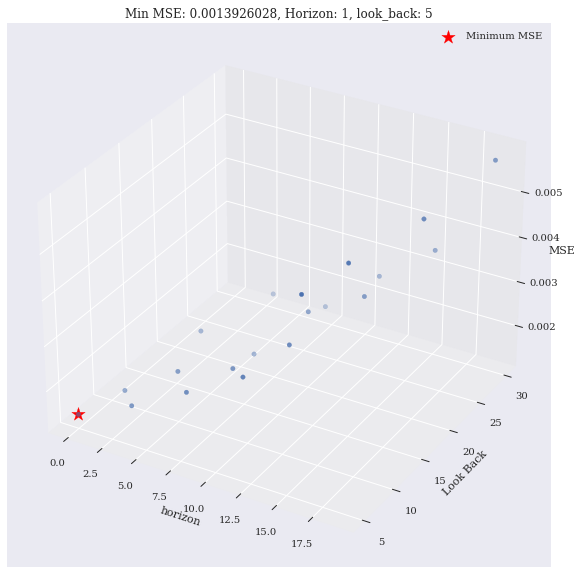

In [108]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(msef.index, msef['look_back'], msef['mse_test'])
ax.set_xlabel('horizon')
ax.set_ylabel('Look Back')
ax.set_zlabel('MSE')

# Get the indices of the minimum MSE value
min_idx = msef['mse_test'].idxmin()
min_horizon = msef.loc[min_idx, 'horizon']
min_lookback = msef.loc[min_idx, 'look_back']
min_mse = msef.loc[min_idx, 'mse_test']

# Plot the minimum MSE point with a different color and marker style
ax.scatter(min_idx, min_lookback, min_mse, color='red', marker='*', s=200, label='Minimum MSE')

plt.legend()
plt.title(f'Min MSE: {min_mse:.10f}, Horizon: {min_horizon}, look_back: {min_lookback}')
plt.show()


In [ ]:
df = Feature_Matrix.copy()
dm = Mid_Price.copy()
split1 = int(len(df)/10)
for i in range(10):
    create_mlps(Feature_Matrix.iloc[, Mid_Price, batch_size)
    

